In [97]:
from collections import Counter, defaultdict
from networkx.utils import groups, not_implemented_for, py_random_state
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import glob
import itertools
import time
import networkx.algorithms.community as nx_commimport 
from statistics import mean
from networkx.algorithms.community import modularity
from networkx.algorithms.community import label_propagation_communities,asyn_lpa_communities
import colorsys

In [98]:
# return dictionary, with  key = community and value = list of nodes
def findDifComBEGIN(labeling):

    com_nodes = {} 
#   key is node and value is its community
    for key, value in labeling.items():
        if value not in com_nodes:
            com_nodes[value] = [key]
        else:
           com_nodes[value].append(key)


    return (com_nodes)

In [99]:
def findRedBlue(nodesInCommunities, G ):
    red= 0
    blue= 0
    comRcBc = defaultdict(list)
    for  node,com  in nodesInCommunities.items():

        if G.nodes()[node]["protected"]==0 :
            red += 1
        else :
            blue +=1
            
        comRcBc[com].append(red)
        comRcBc[com].append(blue)
        red= 0
        blue= 0

    return comRcBc

In [100]:
def findImbalance(comR_B):
    
    #impbalance[0] = 1 - blue/red
    #imbalance[1] = 1 - red/blue
    more_red = {}
    imbalance = defaultdict(list)
    for com,node in comR_B.items():
        if (comR_B[com][1]==0 or comR_B[com][0]==0 ):
            imbalance[com]= 1
            more_red[com]=0
        # else:

        #     mhden = 1-(comR_B[com][1]/comR_B[com][0])
        #     ena = 1-(comR_B[com][0]/comR_B[com][1])
        #     imbalance[com] = [mhden,ena]

        elif(comR_B[com][0]>comR_B[com][1]):
            mhden = 1-(comR_B[com][1]/comR_B[com][0])
            imbalance[com] = mhden
            more_red[com]=1
        else:
            ena = 1-(comR_B[com][0]/comR_B[com][1])
            imbalance[com] = ena
            more_red[com]=0


    return imbalance, more_red

In [101]:
def updatered(more_red,com_Rc_Bc,com):
    
    if (com_Rc_Bc[com][1] < com_Rc_Bc[com][0] ):
        more_red[com] = 1
    else:
        #print("eeeeelanaaa aksdfja;se")
        more_red[com] = 0
    return more_red
            

In [102]:
def updateImbalanceCom(imbalance,more_red,  com_Rc_Bc,com):
    
        more_red = updatered(more_red,com_Rc_Bc,com)

        if (com_Rc_Bc[com][1]==0 or com_Rc_Bc[com][0]==0 ):
            imbalance[com]= 1


        elif(com_Rc_Bc[com][0]>com_Rc_Bc[com][1]):
            mhden = 1-(com_Rc_Bc[com][1]/com_Rc_Bc[com][0])    
            imbalance[com] = mhden
            
        else:
            ena = 1-(com_Rc_Bc[com][0]/com_Rc_Bc[com][1])
            imbalance[com] = ena
        


        return imbalance,more_red
    

In [103]:
def normalize_price(price):
    normalized_price = (price + 1) / 2
    return normalized_price

In [251]:

def sig(x):
    return 1/(1 + np.exp(-x))


def my_labelPropagationThree(G, c,  weight=None, seed=None ):


    labels = {n: i for i, n in enumerate(G)}
    cont = True
    com_Rc_Bc = findRedBlue(labels, G)
    imbalance, more_red = findImbalance(com_Rc_Bc)
    #print("find imbalance at the begining", imbalance)
    random.seed(seed)



    while cont:
        cont = False
        nodes = list(G)
        
        random.shuffle(nodes)

        for node in nodes:
            if not G[node]:
                continue

            # Get label frequencies among adjacent nodes.
            # Depending on the order they are processed in,
            # some nodes will be in iteration t and others in t-1,
            # making the algorithm asynchronous.

            #type of node red = 0, blue = 1 
            typeofnode =int(G.nodes()[node]["protected"])      
            

            if weight is None:
                # initialising a Counter from an iterator of labels is
                # faster for getting unweighted label frequencies
                label_freq = Counter(map(labels.get, G[node]))
               
            else:
                # updating a defaultdict is substantially faster
                # for getting weighted label frequencies
                label_freq = defaultdict(float)
                for _, v, wt in G.edges(node, data=weight, default=1):
                    label_freq[labels[v]] += wt
                
            #normalization of frequencies
            total = sum(label_freq.values(), 0.0)
            # print(total,"total")
            
            for key in label_freq:
                label_freq[key] /= total
                # neo =normalize_to_minus_one_to_one(label_freq[key])
                # label_freq[key]= neo
            #print("freqssdf22222 ",dict(label_freq))

            
            com_Rc_Bc[labels[node]][typeofnode] -=1  
            imbalance, more_red = updateImbalanceCom(imbalance, more_red,com_Rc_Bc,labels[node])
            #print("imbalance",imbalance)
            new_metric = {}
            plus= [ -1, 1]

            for com,freq in label_freq.items():
                imbalance_comnbr = normalize_price(((plus[more_red[com] == typeofnode]))*imbalance[com])

                new_metric[com] = ((freq) *(1-c))+ ((c)*imbalance_comnbr)
                
            # Get the labels that appear with maximum value of new metric.
            max_value = max(new_metric.values())
            # print("max freq is ",max_value)

            best_labels = [label for label, value in new_metric.items() if value == max_value]
            #print("best labels is ", best_labels)
            


            if labels[node] not in best_labels:
                

                #print("label prin thn allagh is ", labels[node])
                labels[node] = random.choice(best_labels)
                #print("label META thn allagh is ", labels[node])         
                cont = True
                # add node in new com
                ##3 peritos kodikas sos
                
            com_Rc_Bc[(labels[node])][typeofnode]+=1 
            imbalance, more_red = updateImbalanceCom(imbalance, more_red,com_Rc_Bc,labels[node])
                
            # #if dont change community return it 
            # ### peritos kwdikas edwww 1!!!!
            # else:

            #     com_Rc_Bc[(labels[node])][typeofnode]+=1 
            #     imbalance, more_red = updateImbalanceCom(imbalance, more_red,com_Rc_Bc,labels[node])
            # #print("labels is ", labels)

    yield from groups(labels).values()


calculate fairness

In [105]:
def initialize_community_attribute_Counter(communitiesList):
    protectedAttributeCountDict = {}
    communityCount = 0
    for i in range(len(communitiesList)):
        protectedAttributeCountDict["Community_{}".format(communityCount)] = {
            0: 0, 1: 0, 2: 0}
        communityCount += 1
    return protectedAttributeCountDict


def count_protected_attributes_frequency(G, communitiesList, protectedAttributeCountDict, attribute):
    communityCount = 0
    for community in communitiesList:

        protectedAttributeCountDict["Community_{}".format(
                        communityCount)][2] = len(community)

        for node in community:
            try:
                
                if G.nodes()[node][attribute] == 0:
                    protectedAttributeCountDict["Community_{}".format(
                        communityCount)][0] += 1
                else:
                    protectedAttributeCountDict["Community_{}".format(
                        communityCount)][1] += 1
            except KeyError:
                continue
        communityCount += 1
    return protectedAttributeCountDict


def calculate_community_balance(protectedAttributeCountDict):
    for x in protectedAttributeCountDict:
        red = protectedAttributeCountDict[x][0]
        blue = protectedAttributeCountDict[x][1]
        if red == 0 and blue == 0:
            pass
        elif red >= blue:
            balance = blue/red
            protectedAttributeCountDict[x]["balance"] = balance
        else:
            balance = red/blue
            protectedAttributeCountDict[x]["balance"] = balance
    return protectedAttributeCountDict


def calculate_Fairness(G, communitiesList, attribute):

    protectedAttributeCountDict = initialize_community_attribute_Counter(
        communitiesList)

    protectedAttributeCountDict = count_protected_attributes_frequency(
        G, communitiesList, protectedAttributeCountDict, attribute)

    protectedAttributeCountDict = calculate_community_balance(
        protectedAttributeCountDict)


    
    if (len(protectedAttributeCountDict)!=1 ):
        df_p = pd.DataFrame(protectedAttributeCountDict)
        df_p = df_p.T

    else:
        df_p = pd.DataFrame(protectedAttributeCountDict["Community_0"], index =["Communtity_0"])


    return df_p


In [106]:
def average_fairness_local(df, path):
    # df = pd.read_csv("comE_communities/output/{}".format(path), sep=",")
    
    
    # if(len(df)==1):
    #     zeroCounts = df[0]
    #     oneCounts = df[1]
    #     com_balance = df["balance"]
    #     nodesINcom = df[2]

    # else:
    zeroCounts = df[0].sum()
    oneCounts = df[1].sum()
    com_balance = df["balance"]
    nodesINcom = df[2]
 
    if zeroCounts > oneCounts:
        balance = oneCounts/zeroCounts
    else:
        balance = zeroCounts/oneCounts
    # balance = min(zeroCounts/oneCounts, oneCounts/zeroCounts)
    averageFairnes = (com_balance*nodesINcom).sum() / nodesINcom.sum()




    # print("Average Fairness for {} is {}".format(path, averageFairnes))
    # print("Global Fairness for {} is {}".format(path, balance))


    return averageFairnes, balance

In [168]:

#, 0.4, 0.3, 0.2, 0.1, 0
def multi_run_average(G,c = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3,0.2,0.1,0],title = "title"):
    df = pd.DataFrame()
    results=[]
    #c = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
    avg_len_ci={}
    for ci in c :
        
        averageA = []
        modA = []
        globalbalanceA = []
        lencomminties=[]
        for i in range(0,20):

            output =(my_labelPropagationThree(G, ci, seed=None))
            # print("output pouy blockarei ",list(output))
            communities = list(output)
            lencom=(len(communities))
            lencomminties.append(lencom)
            df_p = calculate_Fairness(G,communities,"protected")
            

            average, globalbalance = average_fairness_local(df_p,path)
            
            mod = modularity(G,communities)
            
            #for m.o kathe stoixioy poy prepei na deijw
            averageA.append(average)
            modA.append(mod)
            globalbalanceA.append(globalbalance)
        
            
        avg_len_ci[ci]=(mean(lencomminties))
        average = mean(averageA)
        mod = mean(modA)
        globalbalance = mean(globalbalanceA)
        results.append([ci, average, mod, globalbalance,avg_len_ci[ci]])
 

    print(avg_len_ci)
    df.append(results, ignore_index=True)
    # [ci, average, mod, globalbalance]
    my_array = np.array(results)


    

    df_resultsEna = pd.DataFrame(my_array, columns = ['c','Average Fairness','Modularity','Global Fairness','avg_len'])


    file_name = "results/fairLP_results_{}.txt".format(title) 
    # Αποθήκευση του DataFrame σε ένα αρχείο κειμένου (txt)
    df_resultsEna.to_csv(file_name, index=False, sep='\t')


    return(df_resultsEna) 

In [236]:
def makeplots( title):
    file_name = "results/fairLP_results_{}.txt".format(title)
    df = pd.read_csv(file_name, sep='\t')

    print(df)

    fig, ax1 = plt.subplots()
    plt.ylim(0,1.1)

    ax2 = ax1.twinx()

    # Plot the first set of data (Average Fairness and Modularity) on the first y-axis
    plt.plot(df["c"], df["Average Fairness"], label="Average Fairness", marker='o',color='blue')

    # Plot the second set of data (Global Fairness) on the second y-axis
    plt.plot(df["c"], df["Modularity"], label="Modularity", marker='o',color='green')
    plt.ylim(0,1.1)
    # Set labels and title
    ax1.set_xlabel('c')
    ax1.set_ylabel('Average Fairness', color='b')
    
    ax2.set_ylabel('Modularity', color='g')
    plt.title(title)
   

    plt.figure(2)
    
    plt.plot(df["c"], df["avg_len"], marker='o',color='black')
    plt.xlabel('c')
    plt.ylabel('Number of Communities')
    
    plt.show()

In [108]:
def getProtectedAttributes(G, df):
    protected_attributes = dict(zip(df[0], df[1]))
    newG = nx.set_node_attributes(G, protected_attributes, "protected")
    return newG

In [13]:
path = "Datasets/"

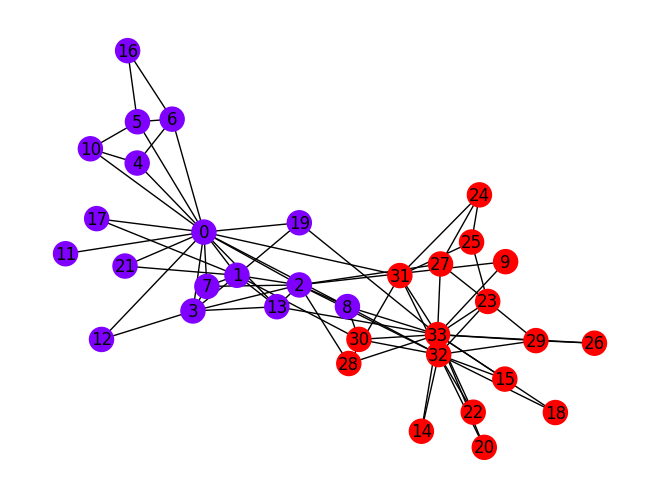

Number of nodes: 34
Number of edges: 78
[(0, {'club': 'Mr. Hi', 'protected': 0}), (1, {'club': 'Mr. Hi', 'protected': 0}), (2, {'club': 'Mr. Hi', 'protected': 0}), (3, {'club': 'Mr. Hi', 'protected': 0}), (4, {'club': 'Mr. Hi', 'protected': 0}), (5, {'club': 'Mr. Hi', 'protected': 0}), (6, {'club': 'Mr. Hi', 'protected': 0}), (7, {'club': 'Mr. Hi', 'protected': 0}), (8, {'club': 'Mr. Hi', 'protected': 0}), (9, {'club': 'Officer', 'protected': 1}), (10, {'club': 'Mr. Hi', 'protected': 0}), (11, {'club': 'Mr. Hi', 'protected': 0}), (12, {'club': 'Mr. Hi', 'protected': 0}), (13, {'club': 'Mr. Hi', 'protected': 0}), (14, {'club': 'Officer', 'protected': 1}), (15, {'club': 'Officer', 'protected': 1}), (16, {'club': 'Mr. Hi', 'protected': 0}), (17, {'club': 'Mr. Hi', 'protected': 0}), (18, {'club': 'Officer', 'protected': 1}), (19, {'club': 'Mr. Hi', 'protected': 0}), (20, {'club': 'Officer', 'protected': 1}), (21, {'club': 'Mr. Hi', 'protected': 0}), (22, {'club': 'Officer', 'protected': 1}

In [17]:


# Create the Karate Club graph
karate = nx.karate_club_graph()

# Assign community attribute to each node
for node in karate.nodes():
    karate.nodes[node]['protected'] = 0 if karate.nodes[node]['club']=='Mr. Hi'  else 1

# Draw the graph with nodes colored by community
pos = nx.spring_layout(karate)
colors = [karate.nodes[node]['protected'] for node in karate.nodes()]
nx.draw(karate, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)

# Show the plot
plt.show()
print("Number of nodes:", karate.number_of_nodes())
print("Number of edges:", karate.number_of_edges())
print(karate.nodes(data=True))


In [240]:

multi_run_average(karate, title='karate_club')

{1: 3.45, 0.9: 3.45, 0.8: 3.4, 0.7: 2.85, 0.6: 2.05, 0.5: 1.3, 0.4: 1.35, 0.3: 1.2, 0.2: 1.45, 0.1: 1.75, 0: 3.5}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,1.000000,0.076525,1.0,3.45
1,0.9,1.000000,0.105601,1.0,3.45
2,0.8,0.994525,0.123897,1.0,3.40
3,0.7,0.983605,0.094557,1.0,2.85
4,0.6,0.983605,0.039366,1.0,2.05
5,0.5,0.938992,0.054644,1.0,1.30
6,0.4,0.901176,0.047567,1.0,1.35
7,0.3,0.920415,0.028401,1.0,1.20
8,0.2,0.785178,0.078303,1.0,1.45
9,0.1,0.619697,0.159085,1.0,1.75


      c  Average Fairness  Modularity  Global Fairness  avg_len
0   1.0          1.000000    0.076525              1.0     3.45
1   0.9          1.000000    0.105601              1.0     3.45
2   0.8          0.994525    0.123897              1.0     3.40
3   0.7          0.983605    0.094557              1.0     2.85
4   0.6          0.983605    0.039366              1.0     2.05
5   0.5          0.938992    0.054644              1.0     1.30
6   0.4          0.901176    0.047567              1.0     1.35
7   0.3          0.920415    0.028401              1.0     1.20
8   0.2          0.785178    0.078303              1.0     1.45
9   0.1          0.619697    0.159085              1.0     1.75
10  0.0          0.054634    0.404827              1.0     3.50


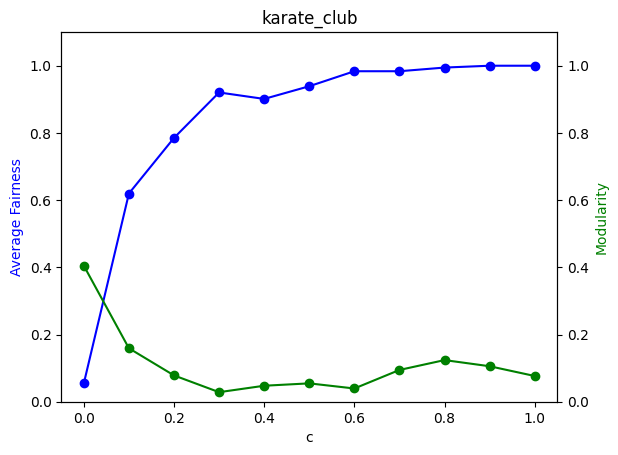

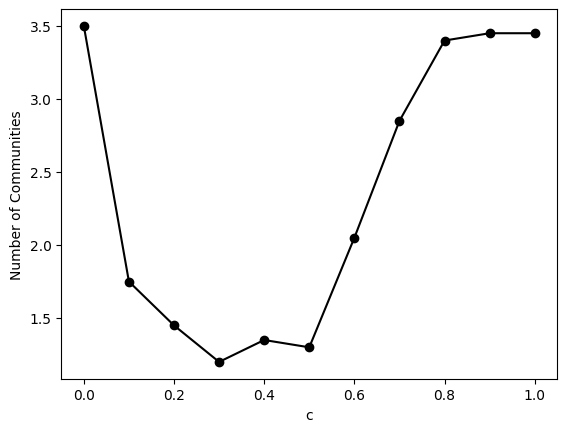

In [241]:

makeplots(title='karate_club')

friendships

Number of nodes: 128
Number of edges: 401
Node labels: ['1', '55', '205', '272', '494', '779', '894', '3', '28', '147', '407', '674', '884', '27', '63', '173', '202', '327', '353', '429', '441', '492', '545', '32', '440', '624', '797', '920', '34', '151', '277', '502', '866', '45', '48', '79', '335', '496', '601', '765', '46', '117', '196', '257', '268', '170', '252', '883', '61', '125', '70', '101', '132', '240', '425', '447', '72', '857', '80', '120', '285', '468', '85', '190', '213', '214', '603', '605', '92', '845', '119', '122', '343', '364', '265', '465', '587', '488', '255', '248', '325', '491', '622', '960', '134', '388', '184', '38', '201', '452', '634', '642', '691', '694', '753', '869', '156', '159', '165', '498', '1332', '200', '480', '245', '211', '242', '219', '222', '867', '232', '798', '959', '564', '275', '312', '612', '769', '486', '531', '771', '520', '576', '577', '1401', '1228', '1519', '1594', '1828']


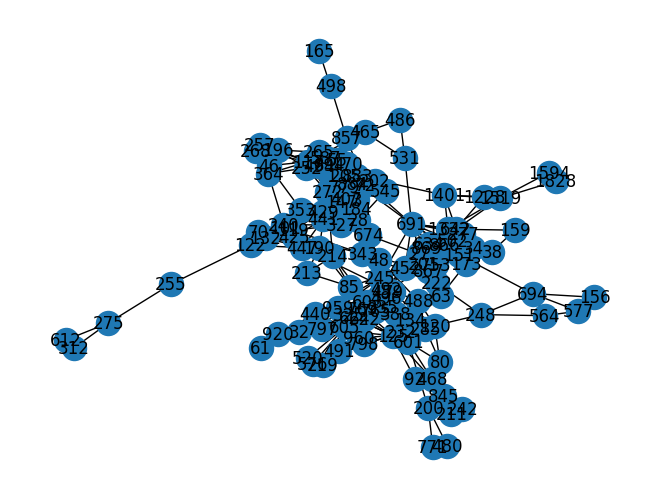

In [189]:

# Step 1: Read CSV File
df_fship = pd.read_csv(r'{}\filarakia.csv', header=None)  # Replace with your actual CSV file name
# Step 2: Split the Cell Values
#print(df_fship)
df_fship = df_fship[0].str.split(expand=True)
#print(df_fship)
# Step 3: Extract Links
links = df_fship.values.tolist()



# Step 4: Create a Graph
G_friendship = nx.Graph()
G_friendship.add_edges_from(links)

# Step 5: Visualize the Graph
pos = nx.spring_layout(G_friendship)  # Positions for all nodes

# Draw the graph
#nx.draw(G_friendship, pos, with_labels=True)

#

# find nodes which is connencted and belong to max componed
G1_friendship = max(nx.connected_components(G_friendship), key=len)

# find graph which apoteleitai apo tous para panw nodes 
G2_friendship = G_friendship.subgraph(G1_friendship)

print("Number of nodes:", G2_friendship.number_of_nodes())
print("Number of edges:", G2_friendship.number_of_edges())
print("Node labels:", list(G2_friendship.nodes()))

# Draw the graph
nx.draw(G2_friendship, pos, with_labels=True)

# Display the plot
plt.show()


In [242]:
# Specify the path to your text file
file_pathlabels = r"{}\gender.txt".format(path)
#file_pathlabels
with open(file_pathlabels) as file:
    lines = file.readlines()
    #print(lines)

labels={}
# Step 2: Process Each Line
for line in lines:
    parts = line.strip().split()  # This will split the line into a list of strings and/or numbers
    #print(parts)
    #for i in range(len(parts)):
    if(parts[2]=="F"):
        labels[(parts[0])]=0
    else:
        labels[(parts[0])]=1

#print(labels)
df_labels = pd.DataFrame(list(labels.items()), columns=[0, 1])
#print(df_labels)

getProtectedAttributes(G2_friendship,df_labels)
#G2_friendship.nodes(data=True)

In [222]:
print("Number of nodes:", G2_friendship.number_of_nodes())
print("Number of edges:", G2_friendship.number_of_edges())


Number of nodes: 128
Number of edges: 401


In [192]:
multi_run_average(G2_friendship,title='friendships')

{1: 32.95, 0.9: 32.35, 0.8: 30.65, 0.7: 31.75, 0.6: 27.85, 0.5: 20.6, 0.4: 15.75, 0.3: 14.5, 0.2: 14.65, 0.1: 15, 0: 18.25}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.706805,0.229965,0.684211,32.95
1,0.9,0.706547,0.263438,0.684211,32.35
2,0.8,0.704844,0.292312,0.684211,30.65
3,0.7,0.705941,0.317578,0.684211,31.75
4,0.6,0.705177,0.407805,0.684211,27.85
5,0.5,0.694961,0.524475,0.684211,20.60
6,0.4,0.628217,0.634515,0.684211,15.75
7,0.3,0.563292,0.653920,0.684211,14.50
8,0.2,0.489521,0.666506,0.684211,14.65
9,0.1,0.479707,0.660447,0.684211,15.00


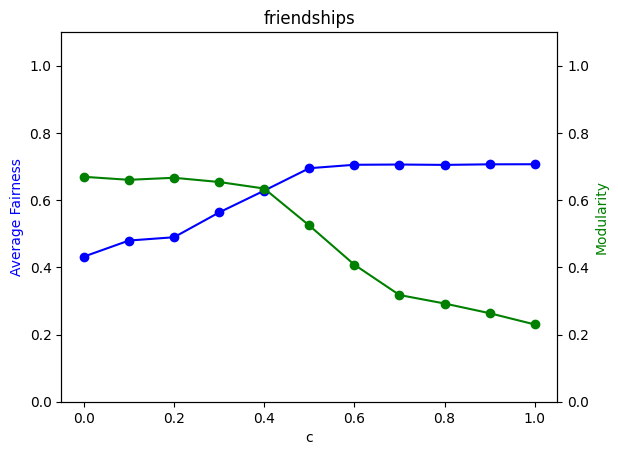

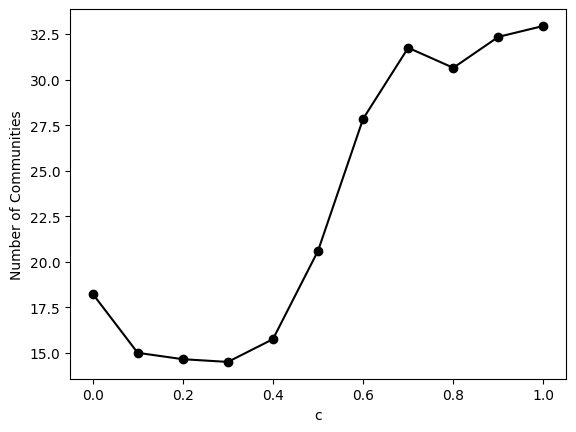

In [228]:
makeplots(title='friendships')

facebook friendships with gender

     node1 node2
1        1   883
4        1   132
8        1   339
9        1   653
11       1   545
...    ...   ...
4510  1543  1594
4511  1543  1784
4512  1594  1828
4513  1594  1784
4514  1594  1870

[1437 rows x 2 columns]
Number of nodes: 156
Number of edges: 1437
Node labels: ['1', '883', '132', '339', '653', '545', '171', '117', '196', '587', '372', '147', '55', '859', '106', '504', '471', '425', '170', '939', '272', '3', '119', '494', '205', '265', '779', '364', '240', '477', '101', '884', '441', '9', '1594', '488', '190', '325', '14', '232', '520', '65', '605', '621', '20', '387', '615', '151', '977', '1232', '513', '634', '156', '691', '34', '1870', '869', '452', '866', '1332', '502', '454', '201', '245', '687', '582', '642', '564', '1401', '753', '38', '159', '577', '857', '124', '725', '274', '871', '111', '202', '62', '428', '544', '122', '275', '63', '991', '448', '145', '343', '923', '346', '70', '649', '429', '763', '80', '941', '85', '214', '213', '650', '440', '447'

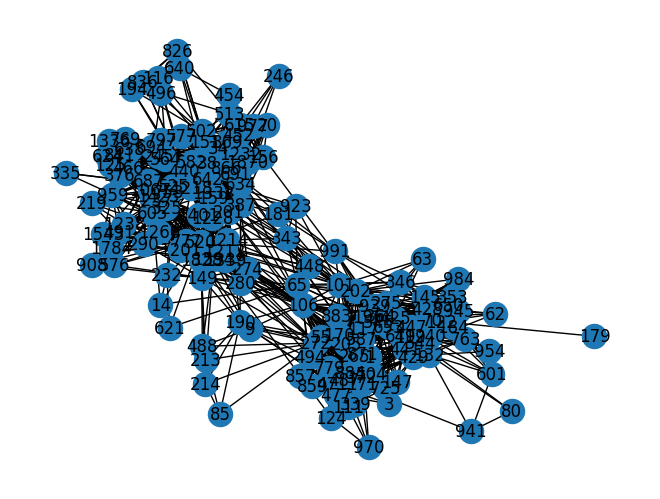

In [243]:


df_fbship = pd.read_csv(r'{}\facefilarakia.csv'.format(path), header=None)  # Replace with your actual CSV file name
# Step 2: Split the Cell Values
df_fbship = df_fbship[0].str.split(expand=True)
df_fbship
df = df_fbship.rename(columns={0: 'node1', 1: 'node2', 2: 'protected'})
df =df[df['protected']=="1"]   #εχω το αν θελω μόνο τις πραγματικές συνδέσεις 
df=df[ ['node1','node2']]



links = df.values.tolist()

G_fbriendship = nx.Graph()
print(df)
G_fbriendship.add_edges_from(links)

# Step 5: Visualize the Graph
pos = nx.spring_layout(G_fbriendship)  # Positions for all nodes

# Draw the graph
#nx.draw(G_friendship, pos, with_labels=True)

#

# find nodes which is connencted and belong to max componed
G1_fbriendship = max(nx.connected_components(G_fbriendship), key=len)

# find graph which apoteleitai apo tous para panw nodes 
G2_fbriendship = G_fbriendship.subgraph(G1_fbriendship)

print("Number of nodes:", G2_fbriendship.number_of_nodes())
print("Number of edges:", G2_fbriendship.number_of_edges())
print("Node labels:", list(G2_fbriendship.nodes()))

# Draw the graph
nx.draw(G2_fbriendship, pos, with_labels=True)

# Display the plot
plt.show()

In [244]:
# Specify the path to your text file
file_pathlabels = r"{}\gender.txt".format(path)
#file_pathlabels
with open(file_pathlabels) as file:
    lines = file.readlines()
    #print(lines)

labels={}
# Step 2: Process Each Line
for line in lines:
    parts = line.strip().split()  # This will split the line into a list of strings and/or numbers
    #print(parts)
    #for i in range(len(parts)):
    if(parts[2]=="F"):
        labels[(parts[0])]=0
    else:
        labels[(parts[0])]=1

#print(labels)
dfb_labels = pd.DataFrame(list(labels.items()), columns=[0, 1])
#print(dfb_labels)

getProtectedAttributes(G2_fbriendship,dfb_labels)
#G2_fbriendship.nodes(data=True)

In [199]:
multi_run_average(G2_fbriendship,title='fb_friendships')

{1: 45.65, 0.9: 44.5, 0.8: 44.8, 0.7: 44.3, 0.6: 41.25, 0.5: 20.15, 0.4: 2.35, 0.3: 3, 0.2: 4.8, 0.1: 5, 0: 5.75}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.834781,0.056010,0.813953,45.65
1,0.9,0.831608,0.077718,0.813953,44.50
2,0.8,0.832904,0.078854,0.813953,44.80
3,0.7,0.832121,0.086594,0.813953,44.30
4,0.6,0.831830,0.134209,0.813953,41.25
5,0.5,0.822878,0.140781,0.813953,20.15
6,0.4,0.816341,0.165733,0.813953,2.35
7,0.3,0.750393,0.247205,0.813953,3.00
8,0.2,0.543286,0.465149,0.813953,4.80
9,0.1,0.492601,0.495139,0.813953,5.00


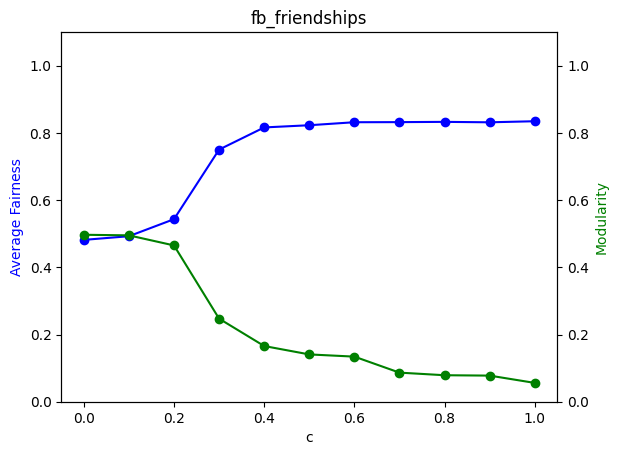

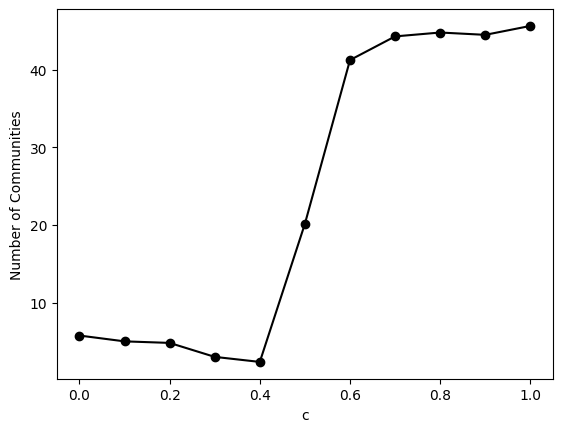

In [229]:
makeplots(title='fb_friendships')

blogs

In [225]:
graph_blogs = nx.read_edgelist("{}/blogs/out_graph.txt".format(path),
                              nodetype=int, delimiter="\t", create_using=nx.Graph())

blog_features = pd.read_csv(
    "{}/blogs/out_community.txt".format(path), delimiter=" ", header=0 , names=[0,1])

getProtectedAttributes(graph_blogs, blog_features)

print("Number of nodes:", graph_blogs.number_of_nodes())
print("Number of edges:", graph_blogs.number_of_edges())


#σετ
blogsgraphLargestCC = max(nx.connected_components(graph_blogs), key=len)
#graph
blogsgraphLargestCC = graph_blogs.subgraph(blogsgraphLargestCC)
print("Number of nodes max_connencted graph:", blogsgraphLargestCC.number_of_nodes())
print("Number of edges max_connencted graph:", blogsgraphLargestCC.number_of_edges())


Number of nodes: 1222
Number of edges: 16717
Number of nodes max_connencted graph: 1222
Number of edges max_connencted graph: 16717


In [202]:
multi_run_average(blogsgraphLargestCC,c=[0,0.1,0.20,0.3,0.4],title='political_blogs')

{0: 9.55, 0.1: 3, 0.2: 3, 0.3: 3, 0.4: 3}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,0.0,0.050622,0.426115,0.921384,9.55
1,0.1,0.882527,0.021937,0.921384,3.00
2,0.2,0.925592,0.000718,0.921384,3.00
3,0.3,0.925592,0.000718,0.921384,3.00
4,0.4,0.925340,0.000735,0.921384,3.00


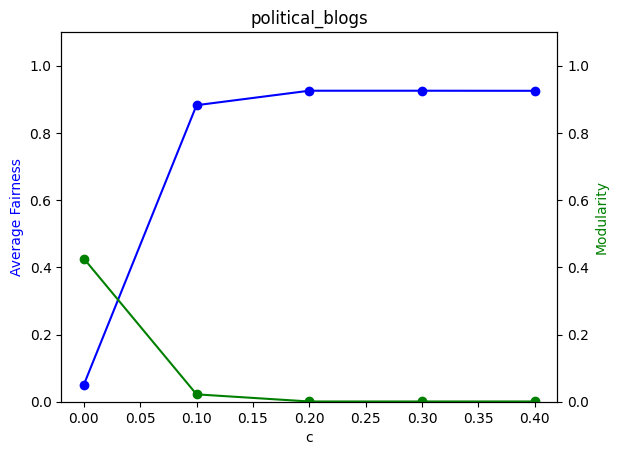

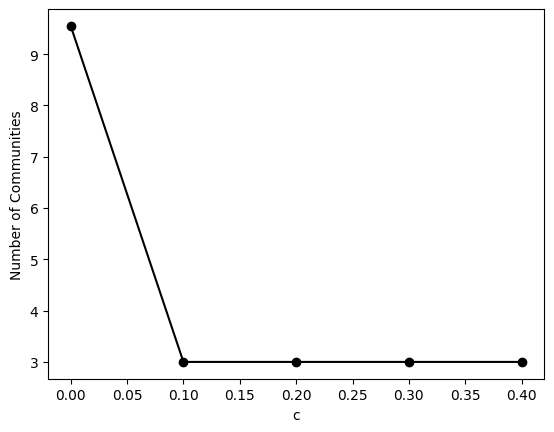

In [230]:
makeplots(title='political_blogs')

fixed Networks

In [138]:
def formyGraph(G,labels,c=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]):
    dictsen={}
    for i in range(0,len(labels)):
        dictsen[i] = int(labels[i])
    df = pd.DataFrame(list(dictsen.items()), columns=[0, 1])
    #print(df)
    getProtectedAttributes(G, df)
    G.nodes(data=True)
    


def generate_distinct_color_hex():
    # Generate a random hue
    hue = random.random()

    # Ensure a minimum level of saturation and brightness for visibility
    saturation = random.uniform(0.5, 1.0)
    brightness = random.uniform(0.7, 1.0)

    # Convert HSV to RGB
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, brightness)

    # Scale to 255 and convert to integers
    r, g, b = int(r * 255), int(g * 255), int(b * 255)

    # Convert to hexadecimal format
    hex_color = '#{:02x}{:02x}{:02x}'.format(r, g, b)

    return hex_color

Gen_graph1

Αριθμός κόμβων: 120
Αριθμός ακμών: 329
['#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#d00f67', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#f43d64', '#74c614', '#74c614', '#74c614', '#74c614', '#74c614', '#74c614', '#74c614', '#74c614', '#74c614', '#74c614', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#88dd5f', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#ce0302', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c72abc', '#c

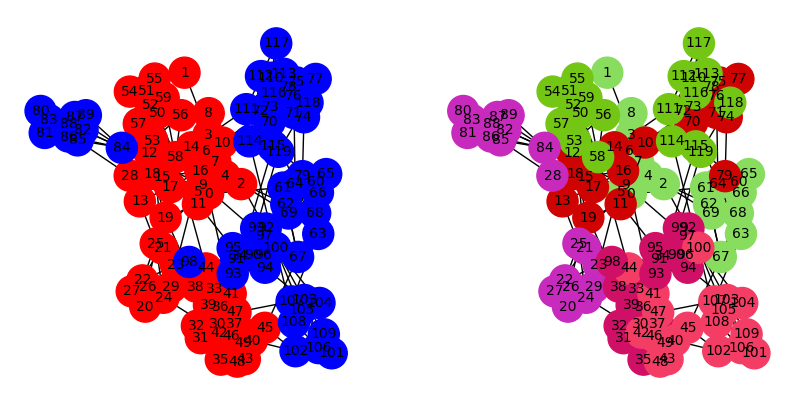

In [248]:


# Specify the path to your text file
file_path = r"{}\data1.txt".format(path)

# Load the data from the text file into a NumPy array
data = np.loadtxt(file_path)

# Print the loaded array
#print(data)


# Specify the path to your text file
file_pathlabels = r"{}\labels.txt".format(path)

# Load the data from the text file into a NumPy array
labels = np.loadtxt(file_pathlabels)

# Print the loaded array
#print(labels)

# Specify the path to your text file
file_pathlabels = r"{}\sensitive.txt".format(path)

# Load the data from the text file into a NumPy array
sensitive = np.loadtxt(file_pathlabels)

# Print the loaded array
#print(sensitive)

# Δημιουργία γράφου από τον πίνακα γειτνίασης
Gen_graph1 = nx.from_numpy_matrix(data)

# Εκτύπωση του αριθμού των κόμβων και ακμών
print("Αριθμός κόμβων:", Gen_graph1.number_of_nodes())
print("Αριθμός ακμών:", Gen_graph1.number_of_edges())

plt.figure(figsize=(10, 5))

# Δημιουργία λίστας με χρώματα ανά ομάδα
labels = {i: int(labels[i]-1) for i in range(len(labels))}
colors = ['r' if labels[node] == 0 else 'b' for node in Gen_graph1.nodes()]

plt.subplot(1, 2, 1)
pos = nx.spring_layout(Gen_graph1)  # Define the layout (spring layout in this case)
nx.draw(Gen_graph1, pos, with_labels=True ,node_size=500, node_color=colors, font_size=10)


sensitive = {i: int(sensitive[i])-1 for i in range(len(sensitive))}




# Generate six visually distinct random colors in hex format
colorsr = [generate_distinct_color_hex() for _ in range(6)]


colors1 = [colorsr[sensitive[node]] for node in Gen_graph1.nodes()]
print(colors1)




#colors1 = ['y' if sensitive[node] == 0 else 'g' if sensitive[node] == 1 else '#00b4d9'  if sensitive[node] == 2 else '#9E2AC6' for node in G.nodes()]

plt.subplot(1, 2, 2)
nx.draw(Gen_graph1, pos, with_labels=True ,node_size=500, node_color=colors1, font_size=10)



plt.show()


In [208]:
formyGraph(Gen_graph1,labels)

In [210]:
multi_run_average(Gen_graph1,title='Gen_graph1')

{1: 16.7, 0.9: 16.95, 0.8: 16.5, 0.7: 14.85, 0.6: 13.2, 0.5: 8.6, 0.4: 6.4, 0.3: 6.7, 0.2: 8.3, 0.1: 11.55, 0: 13.65}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.984946,0.290293,1.0,16.70
1,0.9,0.986377,0.342854,1.0,16.95
2,0.8,0.975267,0.392324,1.0,16.50
3,0.7,0.958199,0.479814,1.0,14.85
4,0.6,0.952267,0.555586,1.0,13.20
5,0.5,0.936795,0.642246,1.0,8.60
6,0.4,0.913955,0.678626,1.0,6.40
7,0.3,0.825163,0.682465,1.0,6.70
8,0.2,0.626919,0.699483,1.0,8.30
9,0.1,0.175003,0.716987,1.0,11.55


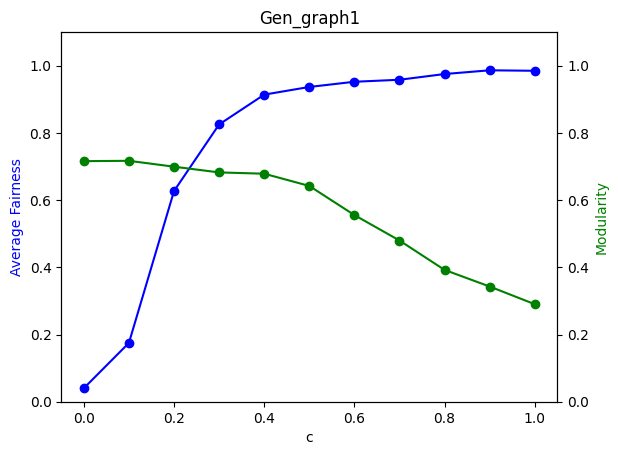

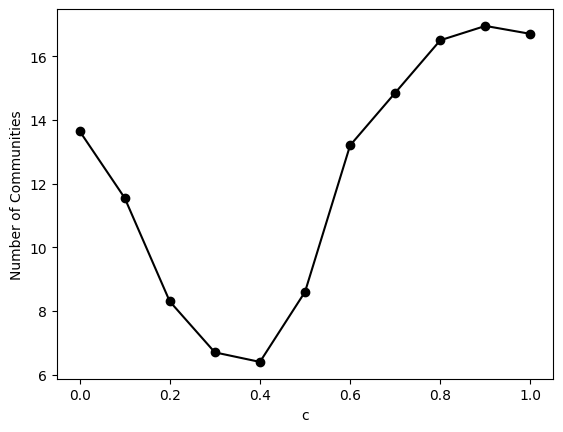

In [231]:
makeplots(title='Gen_graph1')

Gen_graph2

Αριθμός κόμβων: 200
Αριθμός ακμών: 1230
['#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#fb0118', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#91fd58', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#ddc114', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#03b244', '#

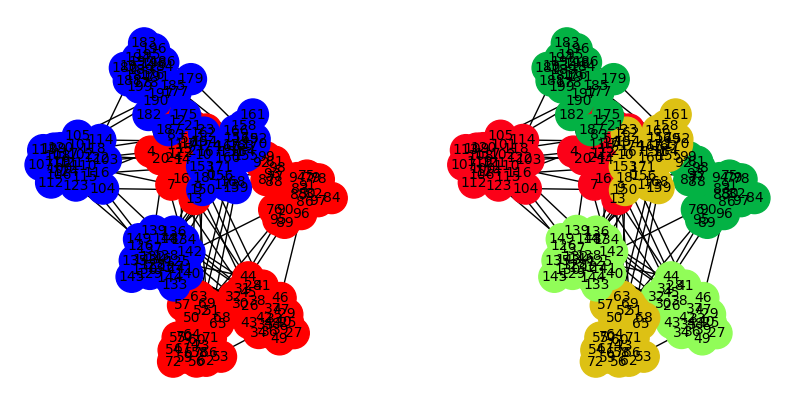

In [249]:



# Specify the path to your text file
file_path4 = r"{}\data4.txt".format(path)

# Load the data from the text file into a NumPy array
data4 = np.loadtxt(file_path4)

# Print the loaded array
#print(data)


# Specify the path to your text file
file_pathlabels4 = r"{}\labels4.txt".format(path)

# Load the data from the text file into a NumPy array
labels4 = np.loadtxt(file_pathlabels4)

# Print the loaded array
#print(labels)

# Specify the path to your text file
file_pathlabels4 = r"{}\sensitive4.txt".format(path)

# Load the data from the text file into a NumPy array
sensitive4 = np.loadtxt(file_pathlabels4)

# Print the loaded array
#print(sensitive)

# Δημιουργία γράφου από τον πίνακα γειτνίασης
Gen_graph4 = nx.from_numpy_matrix(data4)

# Εκτύπωση του αριθμού των κόμβων και ακμών
print("Αριθμός κόμβων:", Gen_graph4.number_of_nodes())
print("Αριθμός ακμών:", Gen_graph4.number_of_edges())

plt.figure(figsize=(10, 5))

# Δημιουργία λίστας με χρώματα ανά ομάδα
labels4 = {i: int(labels4[i]-1) for i in range(len(labels4))}
colors = ['r' if labels4[node] == 0 else 'b' for node in Gen_graph4.nodes()]

plt.subplot(1, 2, 1)
pos = nx.spring_layout(Gen_graph4)  # Define the layout (spring layout in this case)
nx.draw(Gen_graph4, pos, with_labels=True ,node_size=500, node_color=colors, font_size=10)


sensitive4 = {i: int(sensitive4[i])-1 for i in range(len(sensitive4))}




# Generate six visually distinct random colors in hex format
colorsr = [generate_distinct_color_hex() for _ in range(20)]


colors4 = [colorsr[sensitive4[node]] for node in Gen_graph4.nodes()]
print(colors4)




#colors1 = ['y' if sensitive[node] == 0 else 'g' if sensitive[node] == 1 else '#00b4d9'  if sensitive[node] == 2 else '#9E2AC6' for node in G.nodes()]

plt.subplot(1, 2, 2)
nx.draw(Gen_graph4, pos, with_labels=True ,node_size=500, node_color=colors4, font_size=10)



plt.show()




In [217]:
formyGraph(Gen_graph4,labels4)
multi_run_average(Gen_graph4,title='Gen_graph2')


{1: 21.6, 0.9: 21.25, 0.8: 20.05, 0.7: 14.75, 0.6: 7, 0.5: 4, 0.4: 3.9, 0.3: 4.4, 0.2: 4.65, 0.1: 5.9, 0: 8.05}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.994400,0.152767,1.0,21.60
1,0.9,0.996225,0.212105,1.0,21.25
2,0.8,0.970565,0.335948,1.0,20.05
3,0.7,0.983492,0.537439,1.0,14.75
4,0.6,1.000000,0.669615,1.0,7.00
5,0.5,1.000000,0.716158,1.0,4.00
6,0.4,0.963773,0.695680,1.0,3.90
7,0.3,0.837500,0.719886,1.0,4.40
8,0.2,0.790625,0.727655,1.0,4.65
9,0.1,0.496875,0.760600,1.0,5.90


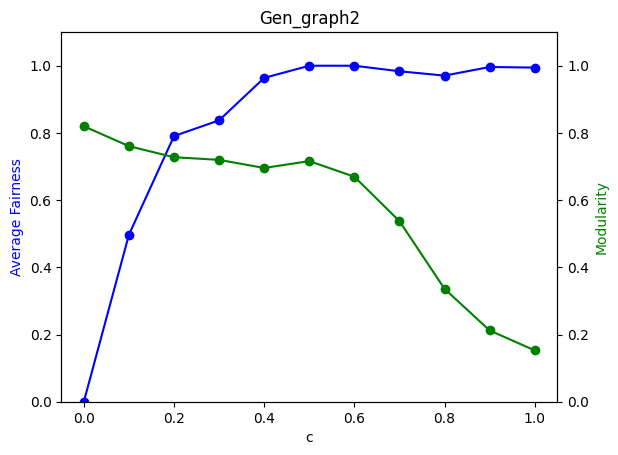

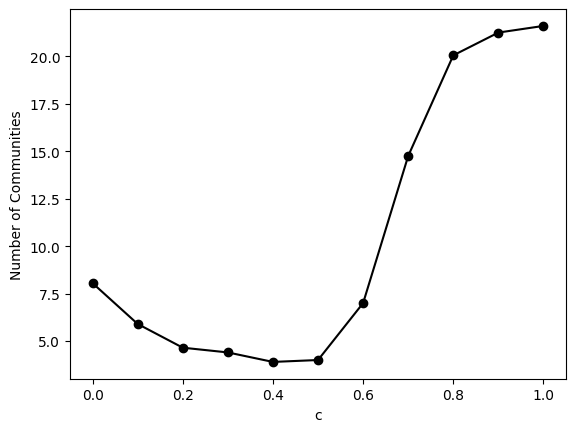

In [232]:
makeplots(title='Gen_graph2')

gen graph 3

Αριθμός κόμβων: 600
Αριθμός ακμών: 14971
['#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '#03a3d7', '

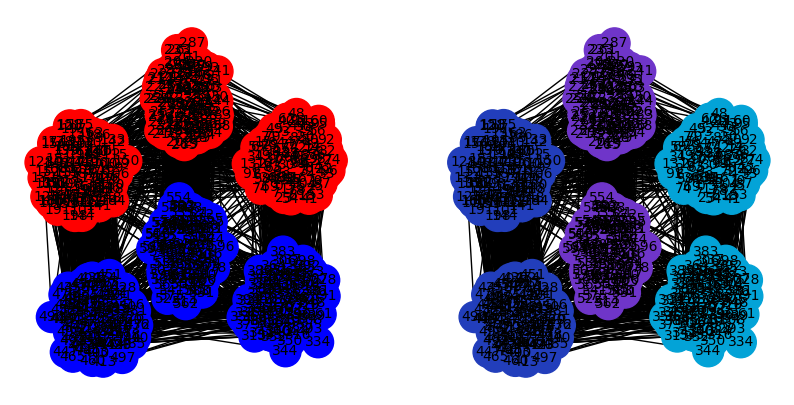

In [213]:



# Specify the path to your text file
file_path3 = r"{}\data3.txt"

# Load the data from the text file into a NumPy array
data3 = np.loadtxt(file_path3)

# Print the loaded array
#print(data)


# Specify the path to your text file
file_pathlabels3 = r"{}\labels3.txt"

# Load the data from the text file into a NumPy array
labels3 = np.loadtxt(file_pathlabels3)

# Print the loaded array
#print(labels)

# Specify the path to your text file
file_pathlabels3 = r"{}\sensitive3.txt"

# Load the data from the text file into a NumPy array
sensitive3 = np.loadtxt(file_pathlabels3)

# Print the loaded array
#print(sensitive)

# Δημιουργία γράφου από τον πίνακα γειτνίασης
Gen_graph3 = nx.from_numpy_matrix(data3)

# Εκτύπωση του αριθμού των κόμβων και ακμών
print("Αριθμός κόμβων:", Gen_graph3.number_of_nodes())
print("Αριθμός ακμών:", Gen_graph3.number_of_edges())

plt.figure(figsize=(10, 5))

# Δημιουργία λίστας με χρώματα ανά ομάδα
labels3 = {i: int(labels3[i]-1) for i in range(len(labels3))}
colors = ['r' if labels3[node] == 0 else 'b' for node in Gen_graph3.nodes()]

plt.subplot(1, 2, 1)
pos = nx.spring_layout(Gen_graph3)  # Define the layout (spring layout in this case)
nx.draw(Gen_graph3, pos, with_labels=True ,node_size=500, node_color=colors, font_size=10)


sensitive3 = {i: int(sensitive3[i])-1 for i in range(len(sensitive3))}




# Generate six visually distinct random colors in hex format
colorsr = [generate_distinct_color_hex() for _ in range(20)]


colors3 = [colorsr[sensitive3[node]] for node in Gen_graph3.nodes()]
print(colors3)




#colors1 = ['y' if sensitive[node] == 0 else 'g' if sensitive[node] == 1 else '#00b4d9'  if sensitive[node] == 2 else '#9E2AC6' for node in G.nodes()]

plt.subplot(1, 2, 2)
nx.draw(Gen_graph3, pos, with_labels=True ,node_size=500, node_color=colors3, font_size=10)



plt.show()




In [214]:
formyGraph(Gen_graph3,labels3)
multi_run_average(Gen_graph3,title='Gen_graph3')

{1: 196.7, 0.9: 197.35, 0.8: 194.05, 0.7: 196.45, 0.6: 195.15, 0.5: 194.75, 0.4: 180.4, 0.3: 46.15, 0.2: 2.75, 0.1: 2.8, 0: 6}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_11268\90949026.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.993864,0.020075,1.0,196.70
1,0.9,0.996442,0.023173,1.0,197.35
2,0.8,0.996754,0.023513,1.0,194.05
3,0.7,0.997336,0.023320,1.0,196.45
4,0.6,0.995884,0.023783,1.0,195.15
5,0.5,0.997009,0.024303,1.0,194.75
6,0.4,0.998184,0.074538,1.0,180.40
7,0.3,0.999681,0.482624,1.0,46.15
8,0.2,1.000000,0.559638,1.0,2.75
9,0.1,1.000000,0.582912,1.0,2.80


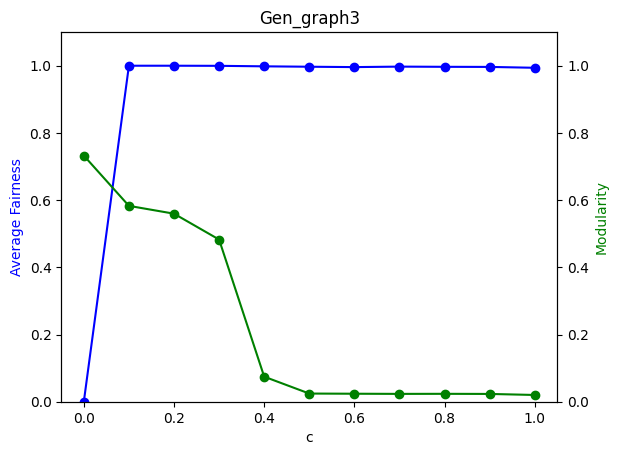

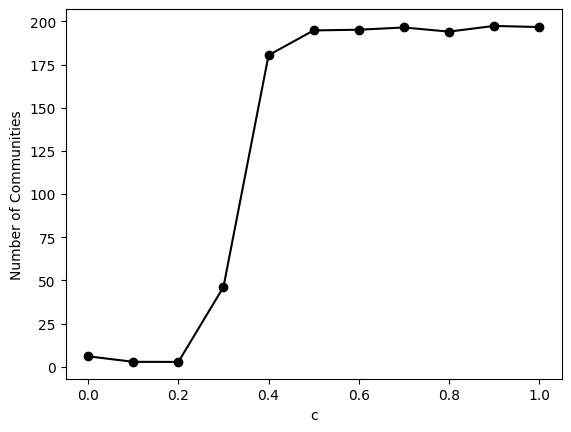

In [233]:
makeplots(title='Gen_graph3')

All plots

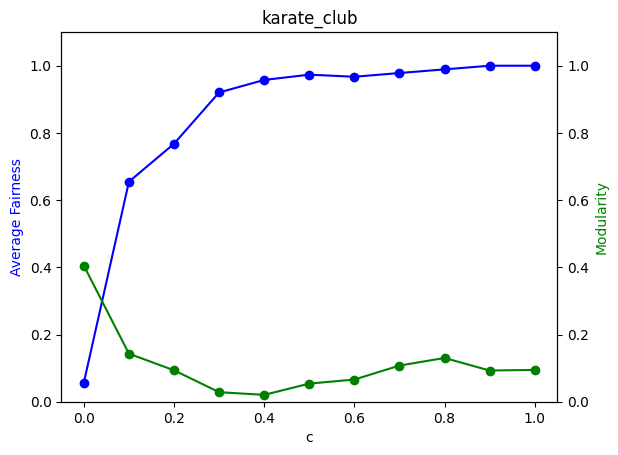

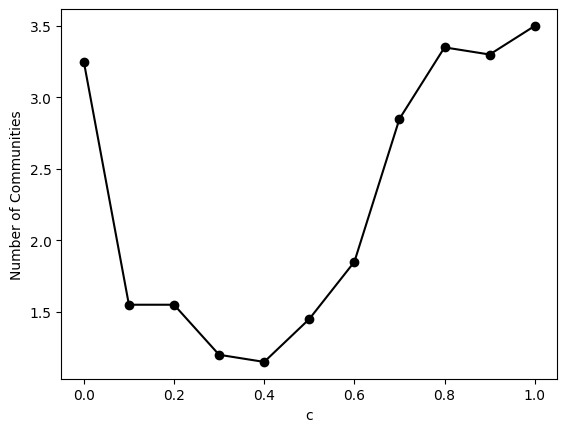

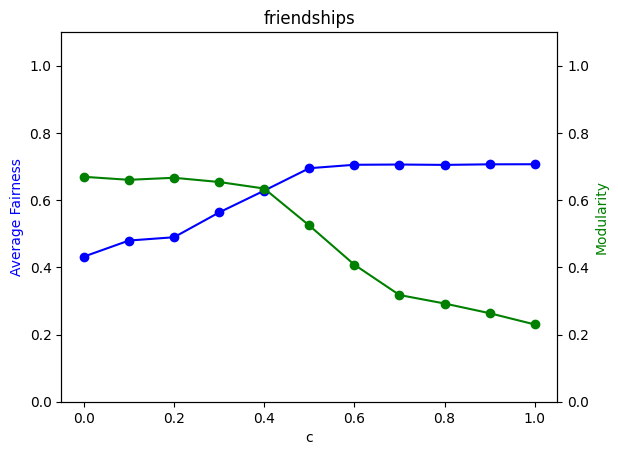

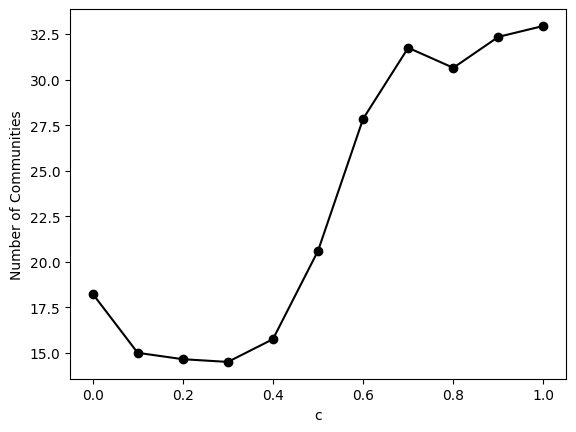

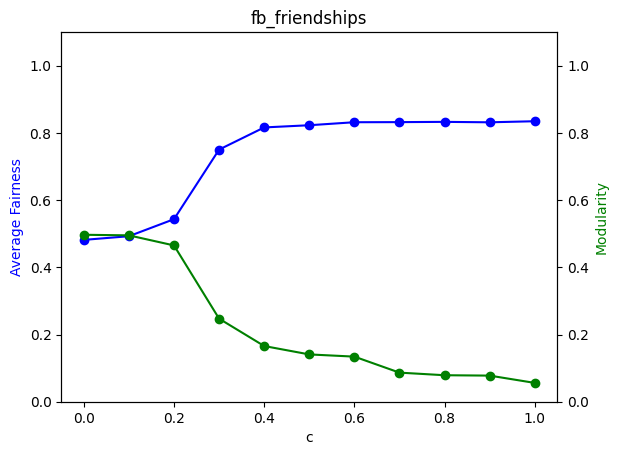

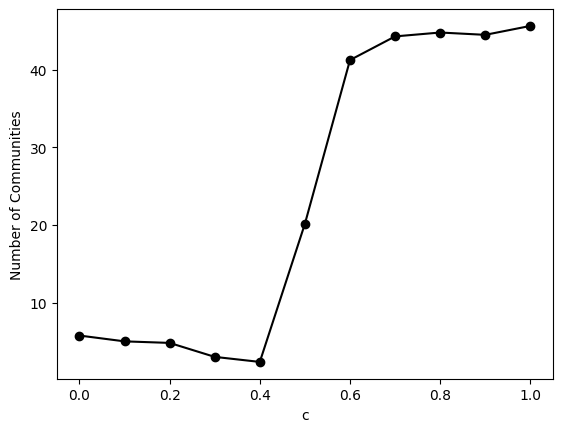

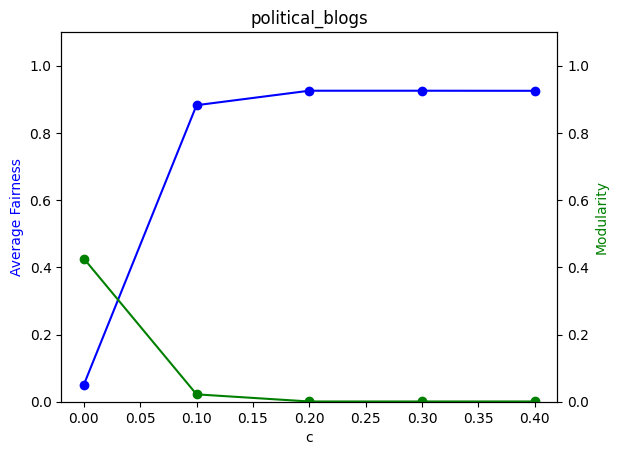

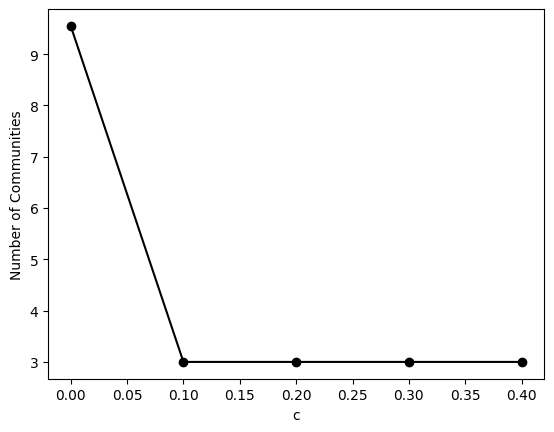

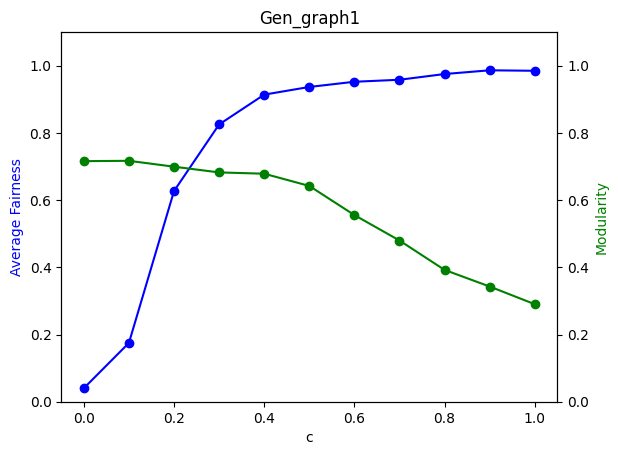

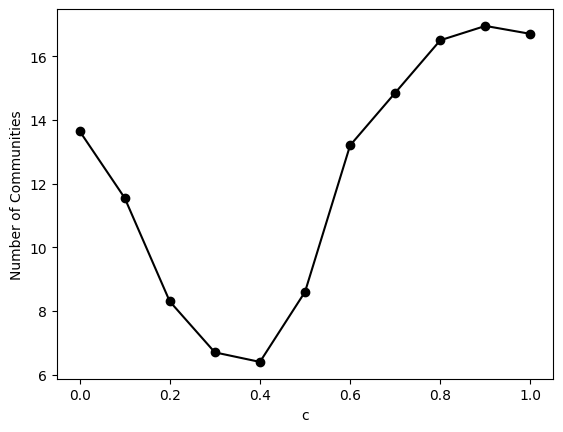

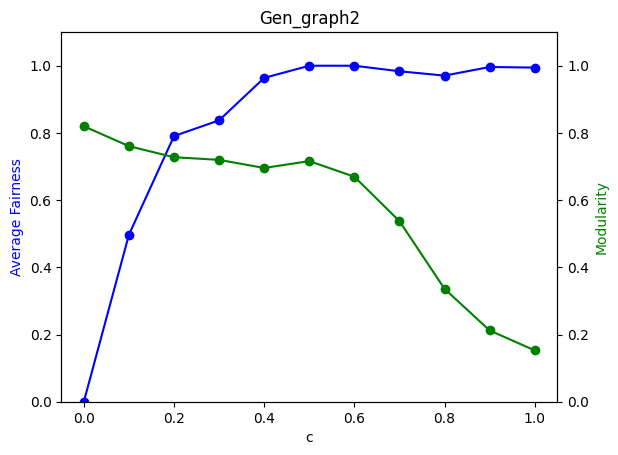

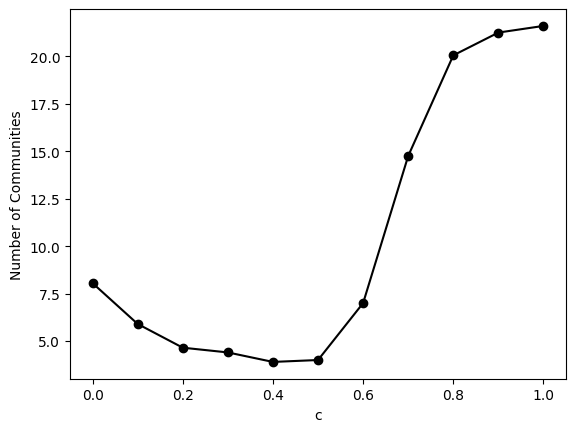

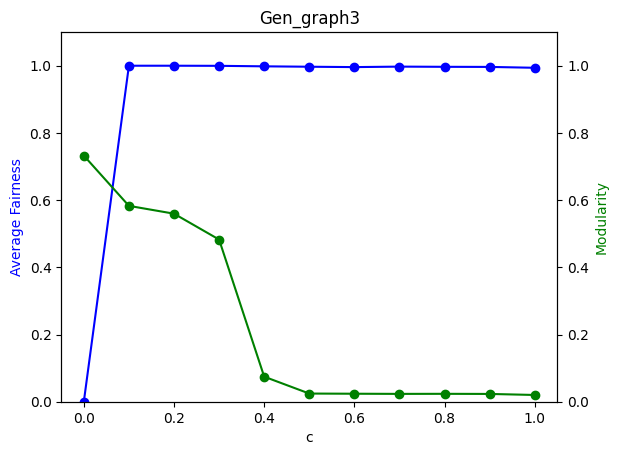

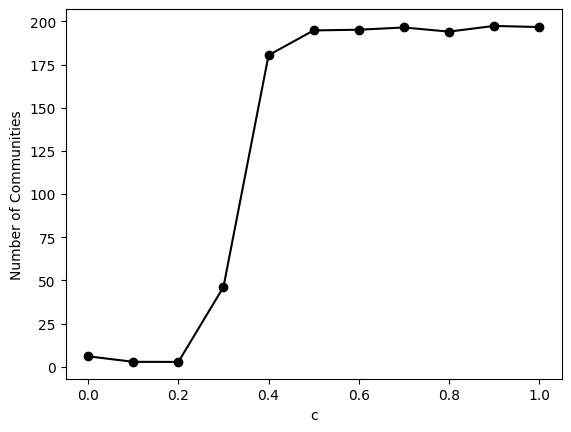

In [235]:

makeplots(title='karate_club')
makeplots(title='friendships')
makeplots(title='fb_friendships')
makeplots(title='political_blogs')
makeplots(title='Gen_graph1')
makeplots(title='Gen_graph2')
makeplots(title='Gen_graph3')